---
title: "Breast Cancer Analysis"
author: "John Torres"
date: "2023-10-05"
format: html
code-fold: false
description: "An analysis of breast cancer data using Python."
---

# Import the Dataset from Kaggle Using API Key

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.model_selection import GridSearchCV
import os
from decouple import config
import os
import kagglehub
import math
import shap
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
import scipy.stats as stats

KAGGLE_USER = config("KAGGLE_USER")
KAGGLE_KEY= config("KAGGLE_KEY")

# Download latest version of the dataset
path = kagglehub.dataset_download("yasserh/breast-cancer-dataset")

print("Path to dataset files:", path)

# List files in the dataset directory
print("Files in dataset:", os.listdir(path))

# Get file name
file_path = os.path.join(path, "breast-cancer.csv")
df = pd.read_csv(file_path)

# Convert the target variable to binary (M: 1, B: 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Display first few rows
print(df.head())

Path to dataset files: /Users/johntorres/.cache/kagglehub/datasets/yasserh/breast-cancer-dataset/versions/1
Files in dataset: ['breast-cancer.csv']
         id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1        17.99         10.38          122.80     1001.0   
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
3  84348301          1        11.42         20.38           77.58      386.1   
4  84358402          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414           

# Dataset Evaluation

In [2]:
# Check for missing values
print("Missing Values in Dataset:")
print(df.isnull().sum())

Missing Values in Dataset:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [3]:
# Dataset Description
print("Dataset Description:")
print(df.info())

Dataset Description:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perim

## Swarm Plot + Box Plots (Checking for Outliers)

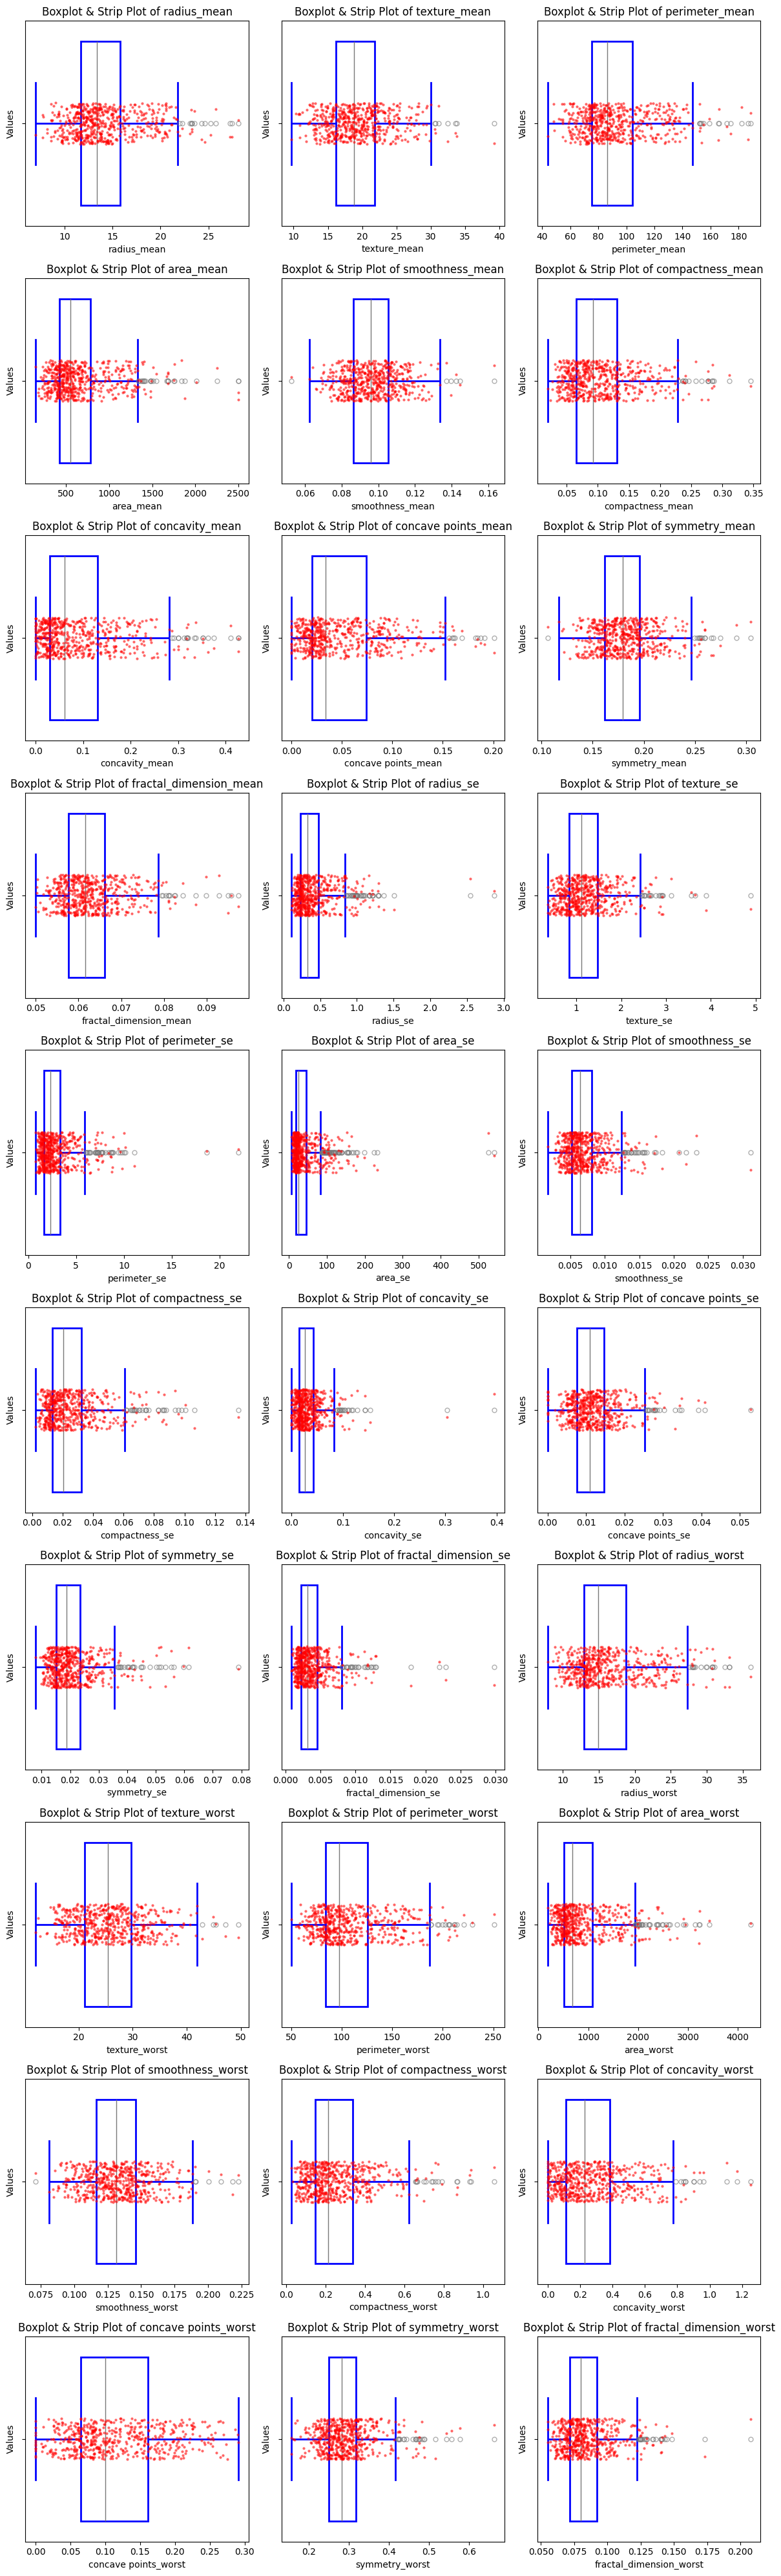

In [4]:
# List of variables to exclude
exclude_vars = ['id', 'diagnosis']

# Boxplots for numerical features, excluding 'var1' and 'var2'
numerical_features = df.select_dtypes(include=[np.number]).columns
numerical_features = [feature for feature in numerical_features if feature not in exclude_vars]

# Calculate the number of rows and columns needed for the subplots
n_cols = 3
n_rows = math.ceil(len(numerical_features) / n_cols)

plt.figure(figsize=(12, 4 * n_rows))
for i, feature in enumerate(numerical_features, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    
    # Create the boxplot with transparent fill and solid blue border
    sns.boxplot(x=df[feature], 
                color='lightblue', 
                boxprops=dict(facecolor='none', linewidth=2, edgecolor='blue'), 
                whiskerprops=dict(linewidth=2, color='blue'),
                capprops=dict(linewidth=2, color='blue'),
                flierprops=dict(marker='o', color='red', markersize=5, alpha=0.6), ax=ax)
    
    # Overlay the strip plot
    sns.stripplot(x=df[feature], color='red', alpha=0.6, jitter=True, size=3, ax=ax)
    
    # Add labels and title
    ax.set_xlabel(feature)  # Label for x-axis
    ax.set_ylabel('Values')  # Label for y-axis
    ax.set_title(f'Boxplot & Strip Plot of {feature}')  # Title for each subplot
plt.tight_layout()
plt.show()

In [5]:
# Remove 'id' and 'diagnosis' columns from features
feature_cols = [col for col in df.columns if col not in ['diagnosis', 'id']]

# Calculate IQR for each feature
Q1 = df[feature_cols].quantile(0.25)
Q3 = df[feature_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create an empty list to store the outliers count for each feature
outliers_list = []

# Loop through each feature and count the number of outliers
for feature in feature_cols:
    # Identify outliers for each feature
    outlier_count = ((df[feature] < lower_bound[feature]) | (df[feature] > upper_bound[feature])).sum()
    outliers_list.append({'Variable': feature, 'Outliers Count': outlier_count})

# Convert the list to a DataFrame for easy display
outliers = pd.DataFrame(outliers_list)

# Sort the DataFrame by feature name (alphabetical order)
outliers_sorted_cnt = outliers.sort_values(by='Outliers Count', ascending=False)

# Display the table of outliers
print("Outliers sorted by Count Acs:")
print(outliers_sorted_cnt.set_index("Variable"))

Outliers sorted by Count Acs:
                         Outliers Count
Variable                               
area_se                              65
radius_se                            38
perimeter_se                         38
area_worst                           35
smoothness_se                        30
fractal_dimension_se                 28
compactness_se                       28
symmetry_se                          27
area_mean                            25
fractal_dimension_worst              24
symmetry_worst                       23
concavity_se                         22
texture_se                           20
concave points_se                    19
concavity_mean                       18
radius_worst                         17
compactness_worst                    16
compactness_mean                     16
symmetry_mean                        15
fractal_dimension_mean               15
perimeter_worst                      15
radius_mean                          14
perimeter_

## Histograms (Checking Skewness)

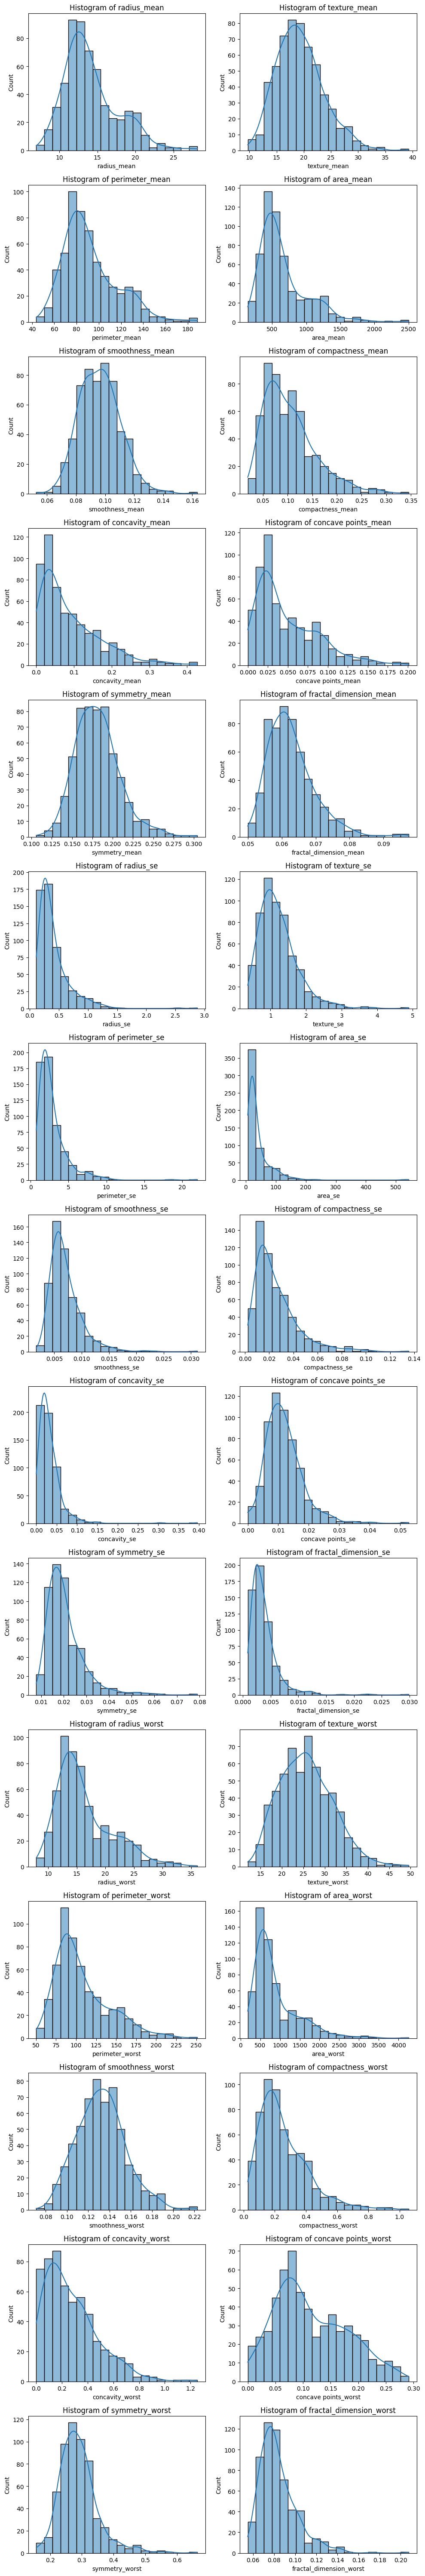

In [6]:
# Exclude specific variables (var1 and var2)
excluded_vars = ['id', 'diagnosis']
df_filtered = df.drop(columns=excluded_vars)

# Number of remaining variables
num_vars = len(df_filtered.columns)

# Dynamically calculate grid size
rows = math.ceil(num_vars / 2)  # Adjust number of rows
cols = min(2, num_vars)  # Max 2 columns per row

# Set plot size
plt.figure(figsize=(cols * 5, rows * 4))

# Loop through remaining numerical columns
for i, col in enumerate(df_filtered.columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df_filtered[col], bins=20, kde=True)
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [7]:
# Compute skewness and kurtosis
stats_table = pd.DataFrame({
    'Variable': df_filtered.columns,
    'Skewness': [stats.skew(df_filtered[col]) for col in df_filtered.columns],
    'Kurtosis': [stats.kurtosis(df_filtered[col], fisher=True) for col in df_filtered.columns]  # Fisher=True gives excess kurtosis
}).set_index('Variable')  # Set 'Variable' as the index to remove default row numbers

# Sort by Skewness (Descending)
stats_table_sorted_skewness = stats_table.sort_values(by='Skewness', ascending=False)

# Sort by Kurtosis (Descending)
stats_table_sorted_kurtosis = stats_table.sort_values(by='Kurtosis', ascending=False)

# Display results
print("\nTable sorted by Skewness (Descending):")
print(stats_table_sorted_skewness)

print("\nTable sorted by Kurtosis (Descending):")
print(stats_table_sorted_kurtosis)


Table sorted by Skewness (Descending):
                         Skewness   Kurtosis
Variable                                    
area_se                  5.432816  48.767196
concavity_se             5.096981  48.422562
fractal_dimension_se     3.913617  26.039950
perimeter_se             3.434530  21.203775
radius_se                3.080464  17.521162
smoothness_se            2.308344  10.367537
symmetry_se              2.189342   7.816388
compactness_se           1.897202   5.050966
area_worst               1.854468   4.347331
fractal_dimension_worst  1.658193   5.188111
texture_se               1.642100   5.291753
area_mean                1.641391   3.609761
compactness_worst        1.469667   3.002120
concave points_se        1.440867   5.070840
symmetry_worst           1.430145   4.395073
concavity_mean           1.397483   1.970592
fractal_dimension_mean   1.301047   2.969017
compactness_mean         1.186983   1.625140
concave points_mean      1.168090   1.046680
concavity_worst

## Log Transformation and Extreme Values Removal

In [9]:
# Apply log transformation to skewed features (example: area_se, radius_se, perimeter_se)
log_transformed_features = ['area_se', 'concavity_se', 'fractal_dimension_se', 'perimeter_se', 'radius_se', 'smoothness_se', 'symmetry_se']  # Add more as needed

transfromed_df = df.copy()

for feature in log_transformed_features:
    transfromed_df[feature] = np.log1p(transfromed_df[feature])  # log1p to avoid log(0)

# Calculate IQR for outlier detection after winsorization
Q1 = transfromed_df[log_transformed_features].quantile(0.25)
Q3 = transfromed_df[log_transformed_features].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on IQR method
df_cleaned = df.copy()  # Make a copy to clean the data without modifying the original
for feature in log_transformed_features:
    df_cleaned = df_cleaned[(df_cleaned[feature] >= lower_bound[feature]) & (df_cleaned[feature] <= upper_bound[feature])]

# Display the cleaned data (for review)
print(df_cleaned.shape)  # Print the shape to see how many rows were removed
print(df_cleaned.head())

(475, 32)
         id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
4  84358402          1        20.29         14.34          135.10     1297.0   
5    843786          1        12.45         15.70           82.57      477.1   
6    844359          1        18.25         19.98          119.60     1040.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
4          0.10030           0.13280          0.1980              0.10430   
5          0.12780           0.17000          0.1578              0.08089   
6          0.09463           0.10900          0.1127              0.07400   

   ...  radius_worst  texture_worst  perimeter

In [ ]:
from scipy.stats import mstats

# List of features to apply the log transformation and winsorization
log_transformed_features = [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 
    'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 
    'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 
    'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 
    'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 
    'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 
    'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

transfromed_test_df = df.copy()

for feature in log_transformed_features:
    transfromed_test_df[feature] = np.log1p(transfromed_test_df[feature])  # log1p to avoid log(0)

# Apply s for extreme outliers (top and bottom 5%)
for feature in log_transformed_features:
    transfromed_test_df[feature] = mstats.winsorize(transfromed_test_df[feature], limits=[0, 0.05])  # Limiting top 5% and bottom 5%

# Calculate IQR for outlier detection after winsorization
Q1 = df[log_transformed_features].quantile(0.25)
Q3 = df[log_transformed_features].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for detecting outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on IQR method
df_cleaned = df.copy()  # Make a copy to clean the data without modifying the original
for feature in log_transformed_features:
    df_cleaned = df_cleaned[(df_cleaned[feature] >= lower_bound[feature]) & (df_cleaned[feature] <= upper_bound[feature])]

# Display the cleaned data (for review)
print(df_cleaned.shape)  # Print the shape to see how many rows were removed
print(df_cleaned.head())

## New Boxplots (Post-Transformation)

In [10]:
print("Original data shape:", df.shape)
print("Cleaned data shape:", df_cleaned.shape)

# Summary statistics before cleaning
print("Summary statistics before cleaning:")
print(df.describe())

# Summary statistics after cleaning
print("Summary statistics after cleaning:")
print(df_cleaned.describe())

Original data shape: (569, 32)
Cleaned data shape: (475, 32)
Summary statistics before cleaning:
                 id   diagnosis  radius_mean  texture_mean  perimeter_mean  \
count  5.690000e+02  569.000000   569.000000    569.000000      569.000000   
mean   3.037183e+07    0.372583    14.127292     19.289649       91.969033   
std    1.250206e+08    0.483918     3.524049      4.301036       24.298981   
min    8.670000e+03    0.000000     6.981000      9.710000       43.790000   
25%    8.692180e+05    0.000000    11.700000     16.170000       75.170000   
50%    9.060240e+05    0.000000    13.370000     18.840000       86.240000   
75%    8.813129e+06    1.000000    15.780000     21.800000      104.100000   
max    9.113205e+08    1.000000    28.110000     39.280000      188.500000   

         area_mean  smoothness_mean  compactness_mean  concavity_mean  \
count   569.000000       569.000000        569.000000      569.000000   
mean    654.889104         0.096360          0.104341 

# Descriptive Statistics

In [11]:
# Descriptive Statistics
print("Dataset Overview:")
print(df.info())
print("\nSummary Statistics:")
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int64  
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimete

## Exploratory Data Analysis (EDA)

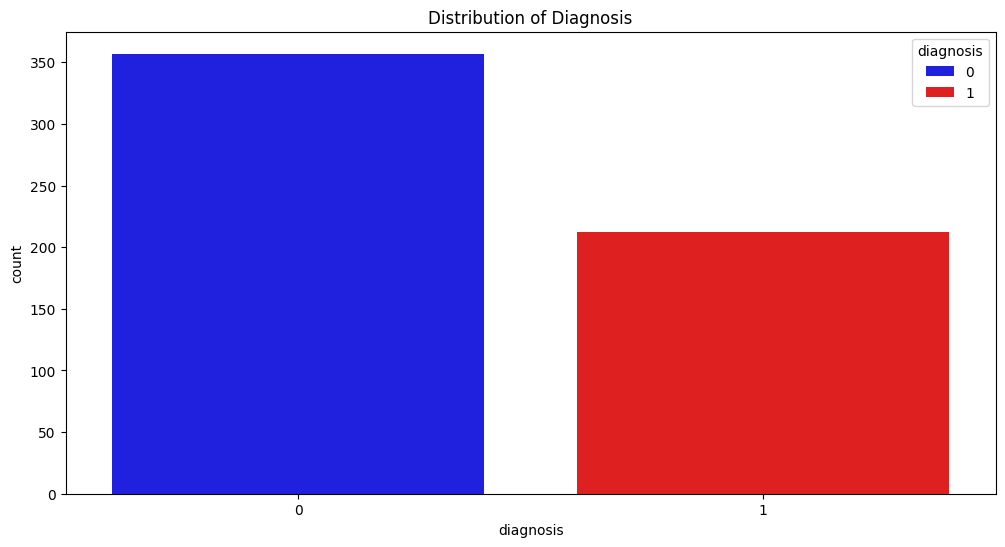

In [12]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='diagnosis', hue='diagnosis', palette={1: 'red', 0: 'blue'})
plt.title('Distribution of Diagnosis')
plt.show()

## Correlation Heatmap

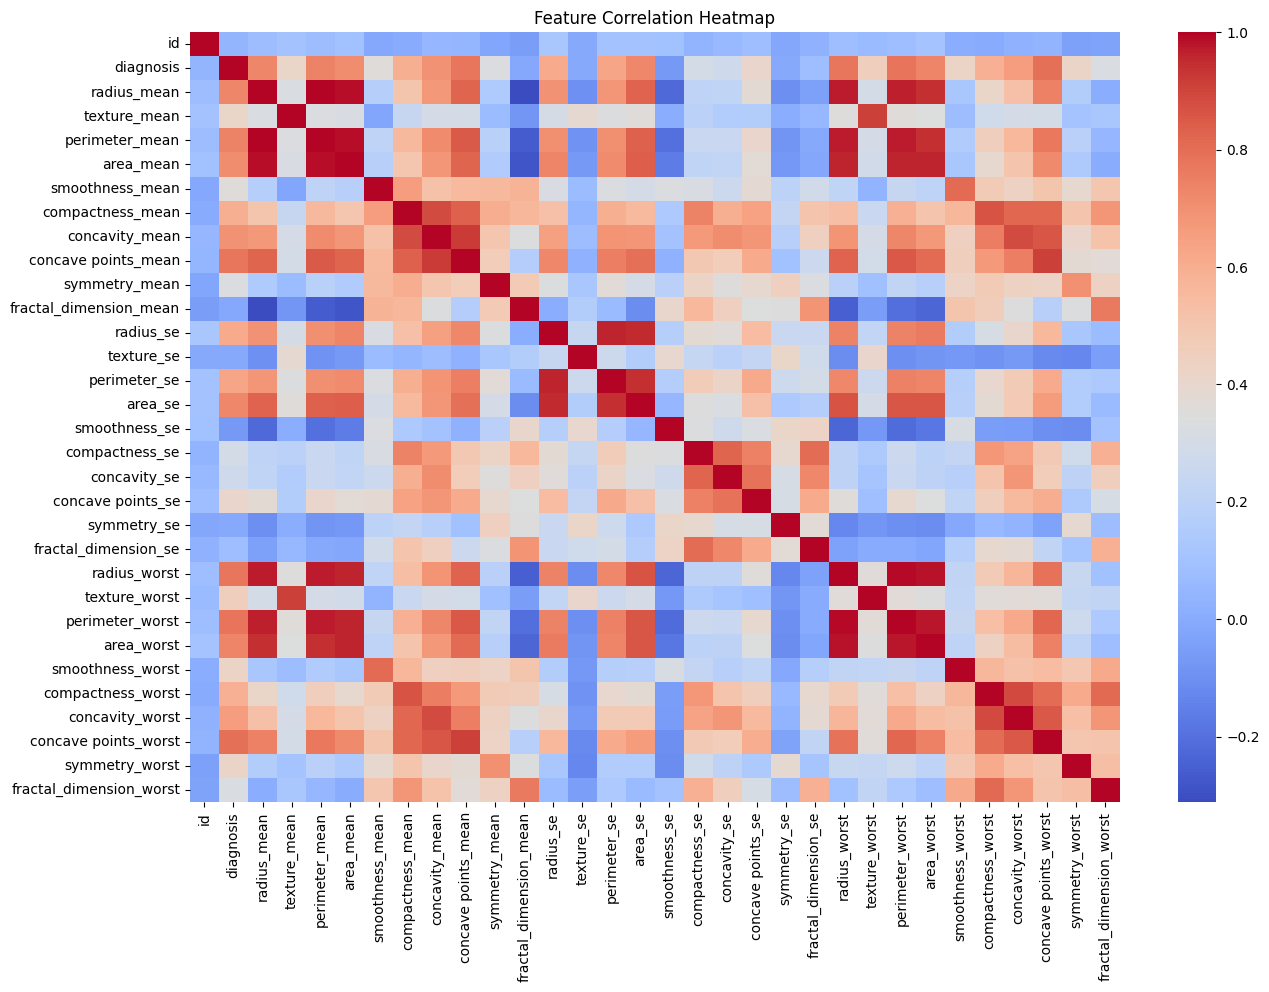

In [13]:
# Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

### Correlation Matrix

In [15]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Display the correlation matrix as a table
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                               id  diagnosis  radius_mean  texture_mean  \
id                       1.000000   0.039769     0.074626      0.099770   
diagnosis                0.039769   1.000000     0.730029      0.415185   
radius_mean              0.074626   0.730029     1.000000      0.323782   
texture_mean             0.099770   0.415185     0.323782      1.000000   
perimeter_mean           0.073159   0.742636     0.997855      0.329533   
area_mean                0.096893   0.708984     0.987357      0.321086   
smoothness_mean         -0.012968   0.358560     0.170581     -0.023389   
compactness_mean         0.000096   0.596534     0.506124      0.236702   
concavity_mean           0.050080   0.696360     0.676764      0.302418   
concave points_mean      0.044158   0.776614     0.822529      0.293464   
symmetry_mean           -0.022114   0.330499     0.147741      0.071401   
fractal_dimension_mean  -0.052511  -0.012838    -0.311631     -0.076437   
radiu

### Correlation Matrix
(This will help to determine which variables to drop to avoid multicollinearity)

In [58]:
# Optional: Sort the correlation matrix for easier analysis
sorted_correlation_matrix = correlation_matrix.unstack().sort_values(ascending=False)

# Display the sorted correlation matrix (ignoring self-correlations, which are always 1)
sorted_correlation_matrix = sorted_correlation_matrix[sorted_correlation_matrix != 1]
print("\nSorted Correlation Matrix (excluding self-correlations):")
print(sorted_correlation_matrix)


Sorted Correlation Matrix (excluding self-correlations):
perimeter_mean          radius_mean               0.997855
radius_mean             perimeter_mean            0.997855
radius_worst            perimeter_worst           0.993708
perimeter_worst         radius_worst              0.993708
area_mean               radius_mean               0.987357
                                                    ...   
perimeter_mean          fractal_dimension_mean   -0.261477
area_mean               fractal_dimension_mean   -0.283110
fractal_dimension_mean  area_mean                -0.283110
                        radius_mean              -0.311631
radius_mean             fractal_dimension_mean   -0.311631
Length: 992, dtype: float64


# Question 1: Can we accurately predict malignancy?

In [78]:
# Define feature columns (all except 'diagnosis' and 'id')
feature_cols = [col for col in df.columns if col not in ['diagnosis', 'id']]
X = df[feature_cols]
y = df['diagnosis']

# Split the dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Question 1: Can we accurately predict malignancy? ---
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Model Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Logistic Model Diagnostics

### Overfitting

In [79]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

# Predictions on training data
y_train_pred = log_reg.predict(X_train_scaled)
y_train_proba = log_reg.predict_proba(X_train_scaled)[:, 1]

# Predictions on test data
y_test_pred = log_reg.predict(X_test_scaled)
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# Training performance
train_acc = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

# Test performance
test_acc = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

# Print results
print("Training Set Performance:")
print(f"Accuracy: {train_acc:.4f}, ROC-AUC: {train_auc:.4f}")
print(classification_report(y_train, y_train_pred))

print("\nTest Set Performance:")
print(f"Accuracy: {test_acc:.4f}, ROC-AUC: {test_auc:.4f}")
print(classification_report(y_test, y_test_pred))

# Check for Overfitting
if train_acc - test_acc > 0.05:
    print("\n⚠️ Potential Overfitting: Training accuracy significantly higher than test accuracy.")
else:
    print("\n✅ No significant signs of overfitting detected.")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_log)
print("Confusion Matrix:\n", conf_matrix)

# ROC-AUC score
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

Training Set Performance:
Accuracy: 0.9846, ROC-AUC: 0.9977
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       285
           1       0.99      0.97      0.98       170

    accuracy                           0.98       455
   macro avg       0.99      0.98      0.98       455
weighted avg       0.98      0.98      0.98       455


Test Set Performance:
Accuracy: 0.9737, ROC-AUC: 0.9964
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


✅ No significant signs of overfitting detected.
Confusion Matrix:
 [[71  1]
 [ 2 40]]
ROC-AUC Score: 1.00


### Plots for Evaluation

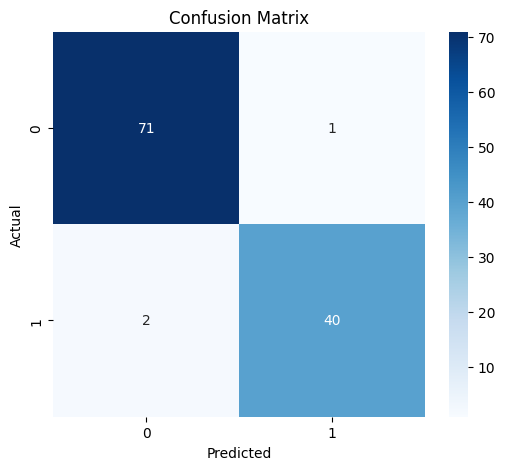

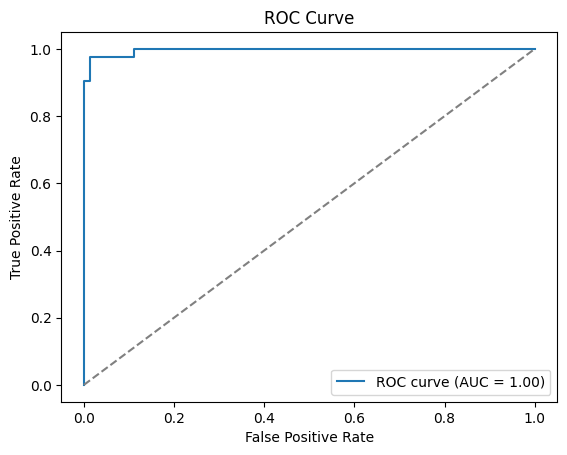

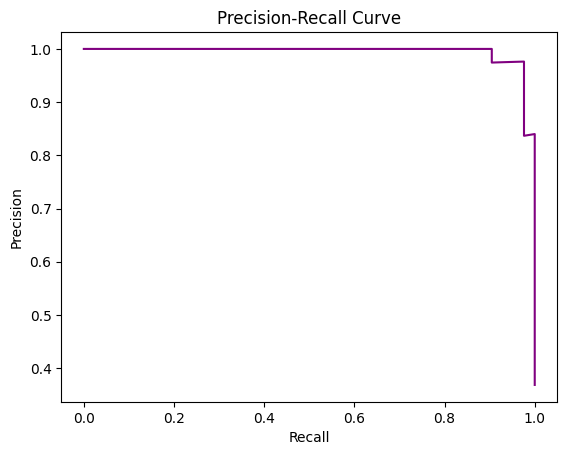

In [80]:
# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precisions, recalls, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recalls, precisions, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

### Assumption Checks

####  Linearity of Log-Odds (Logit)

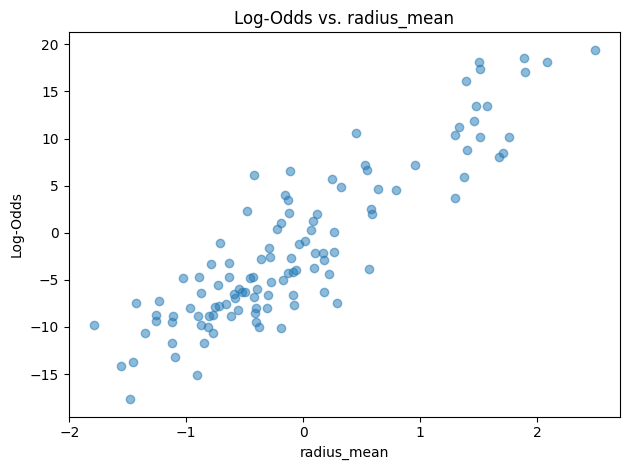

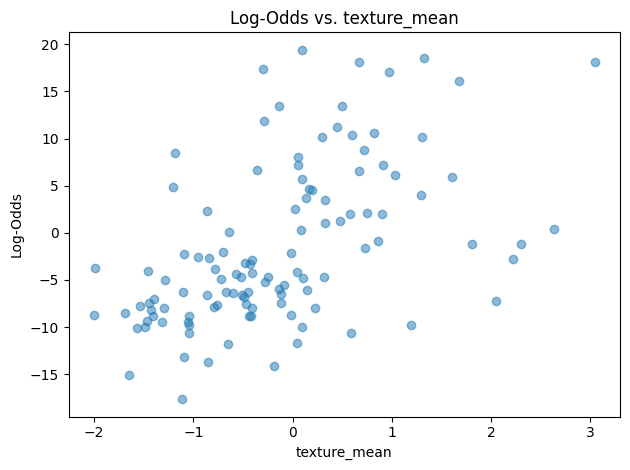

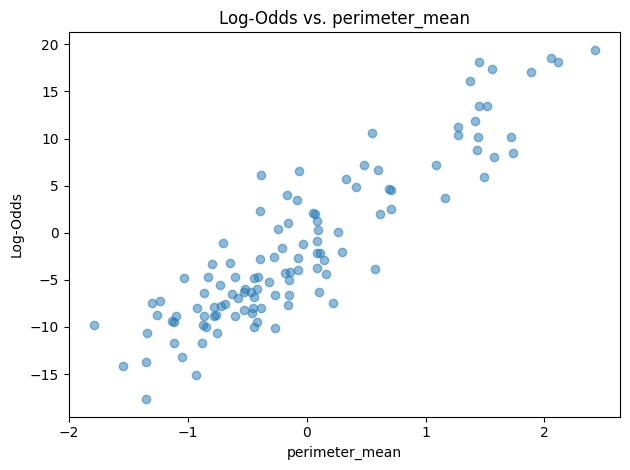

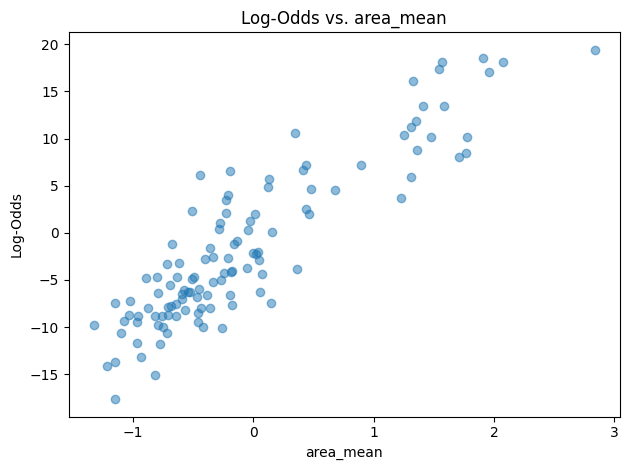

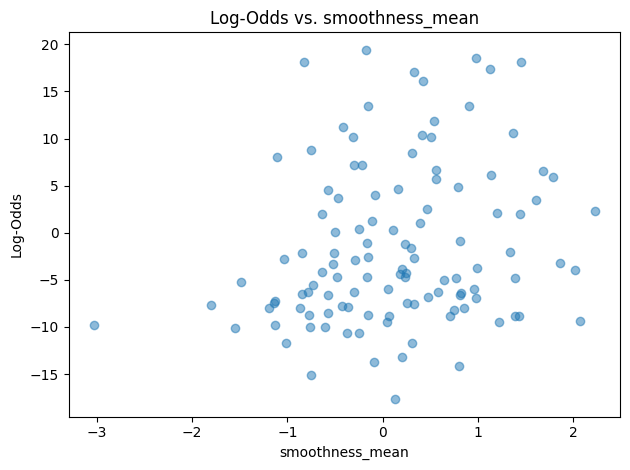

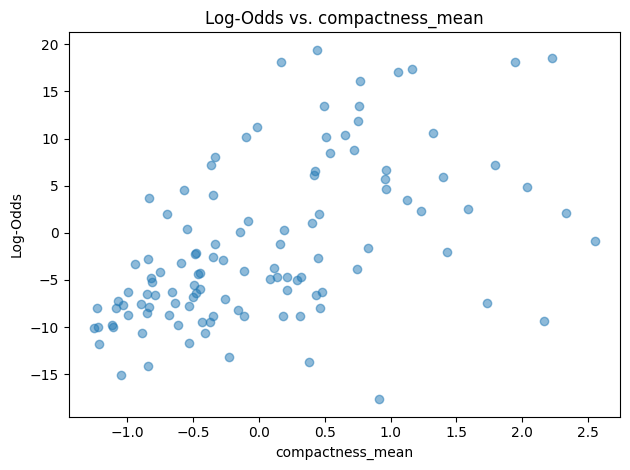

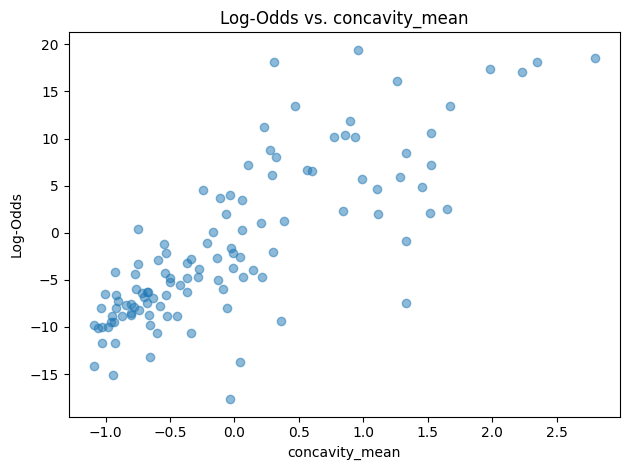

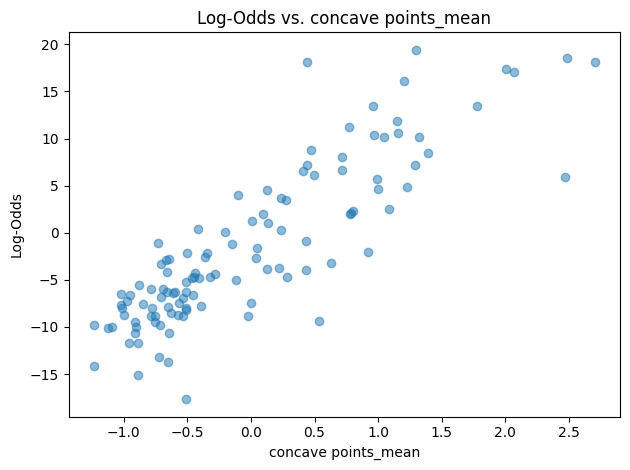

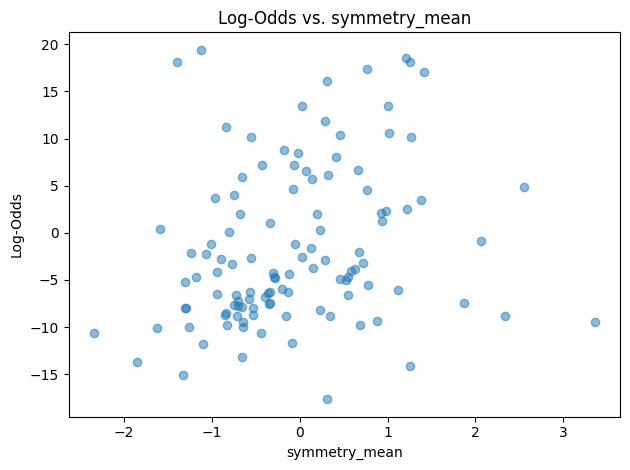

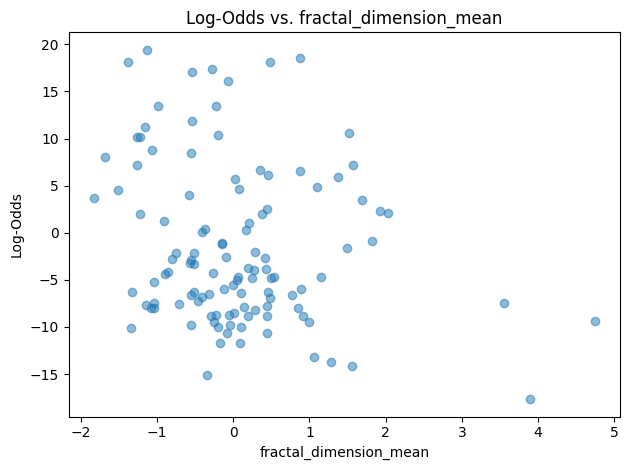

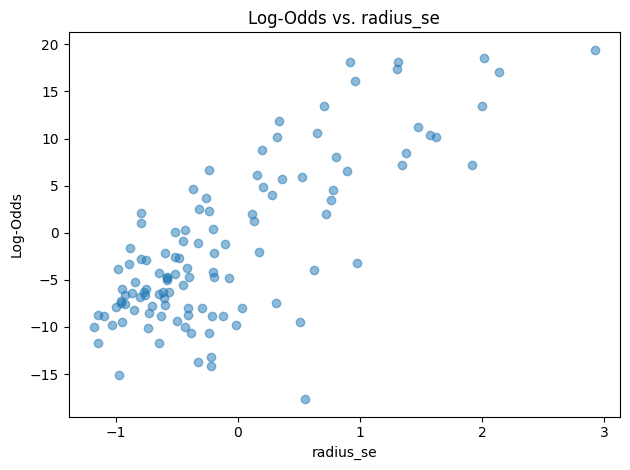

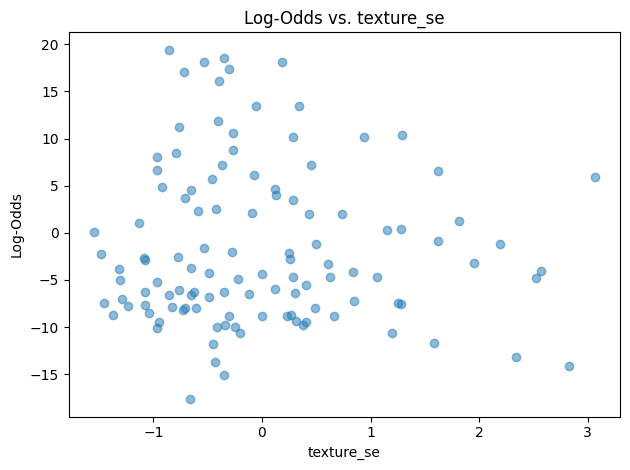

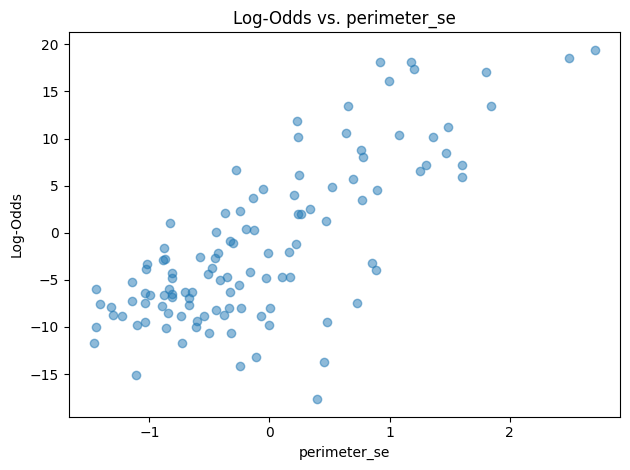

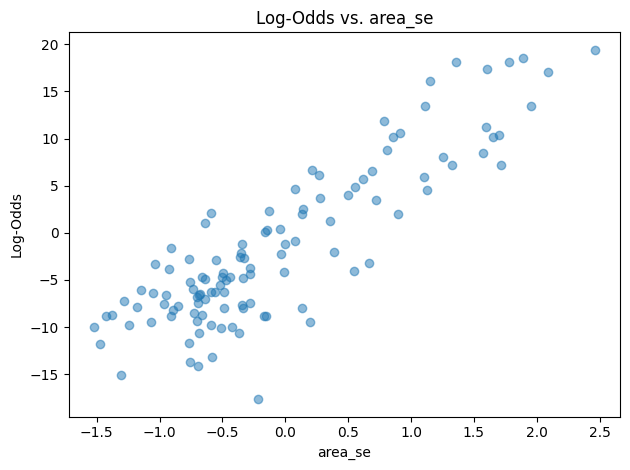

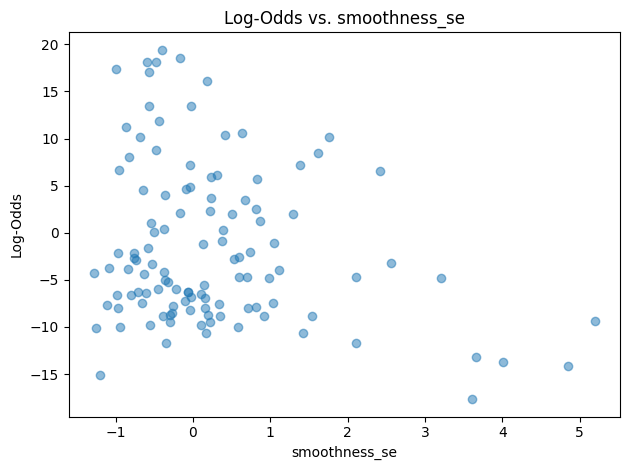

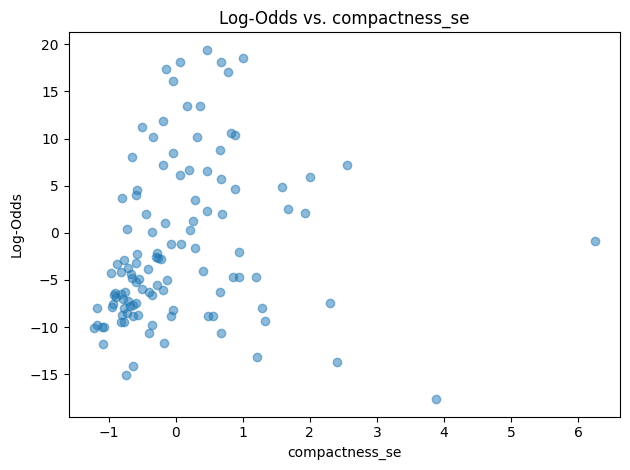

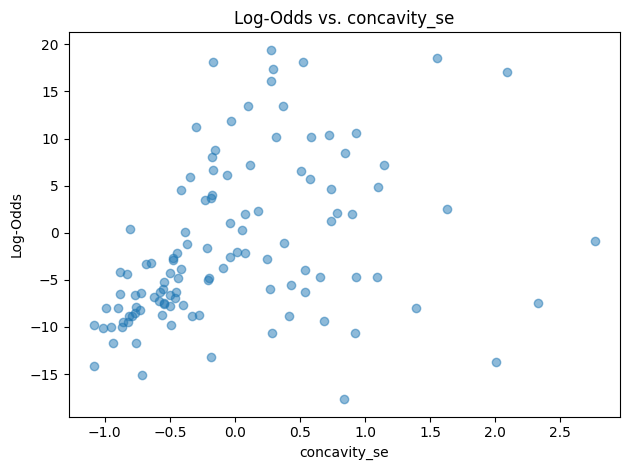

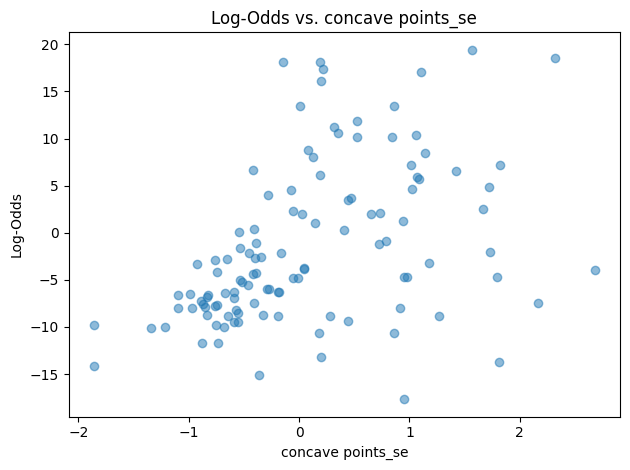

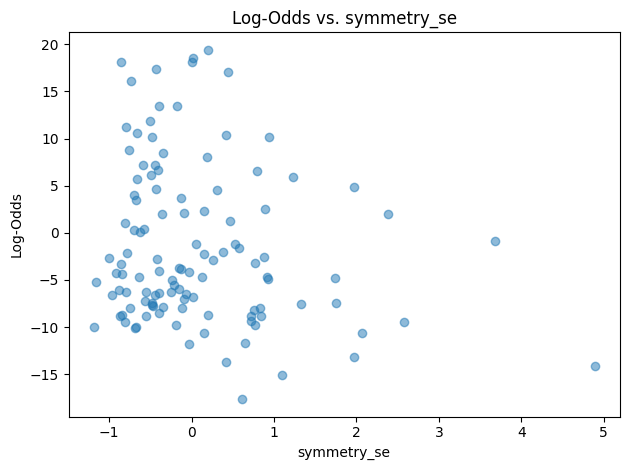

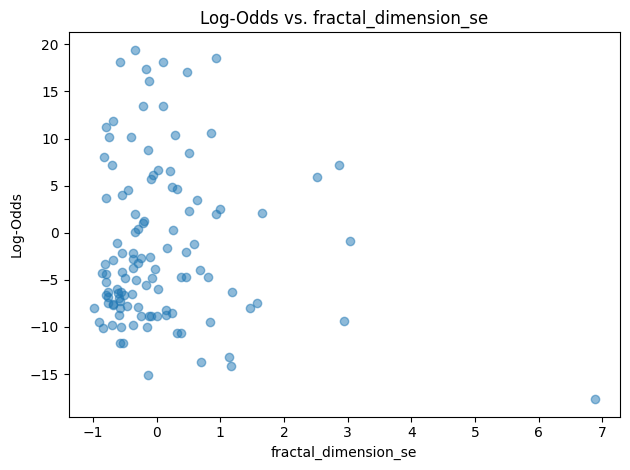

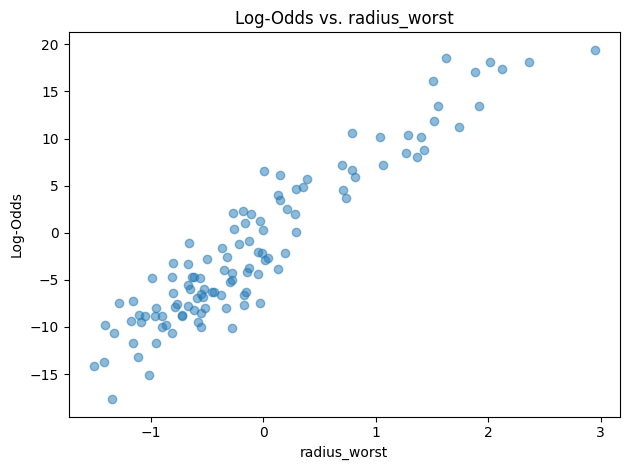

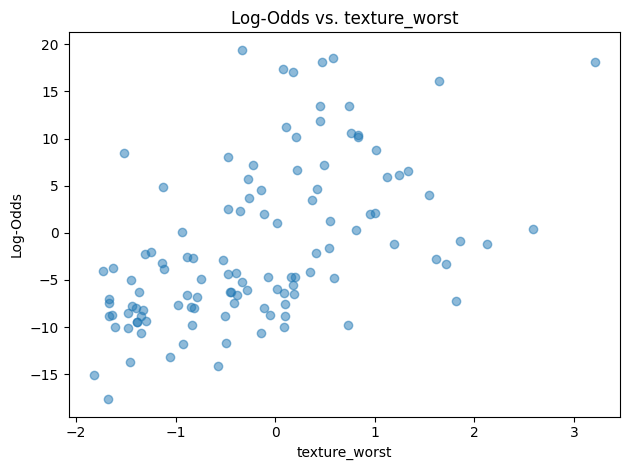

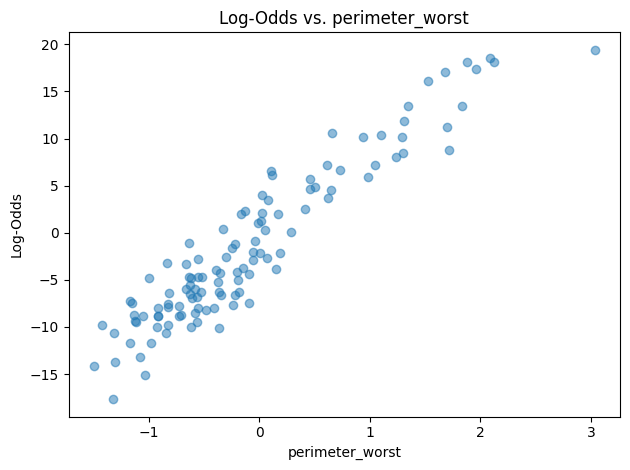

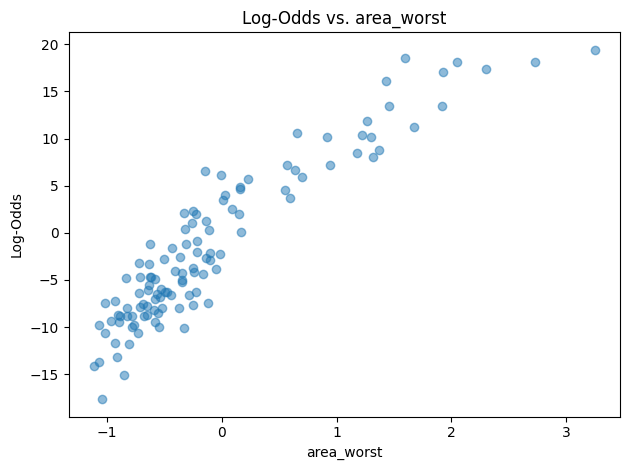

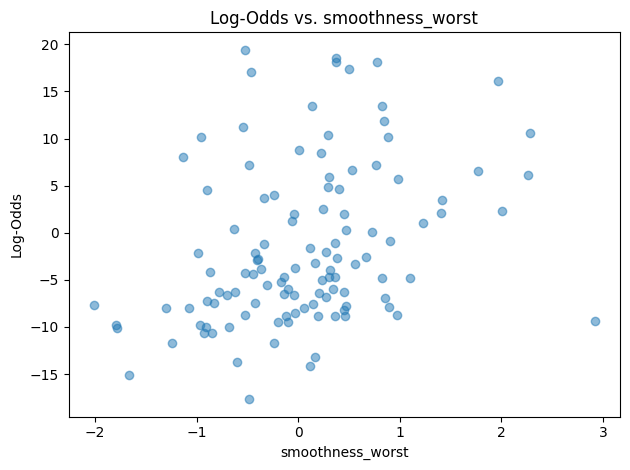

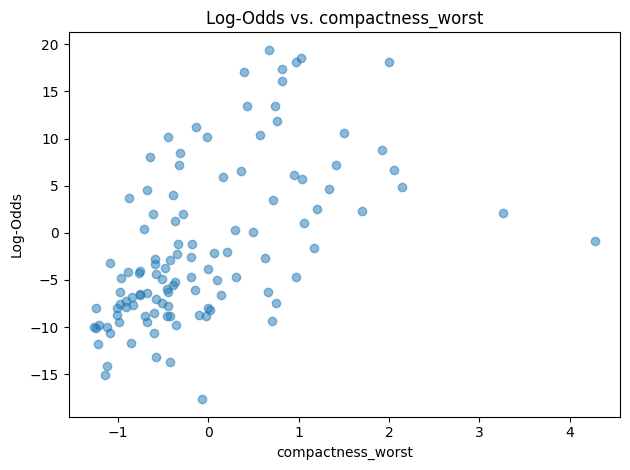

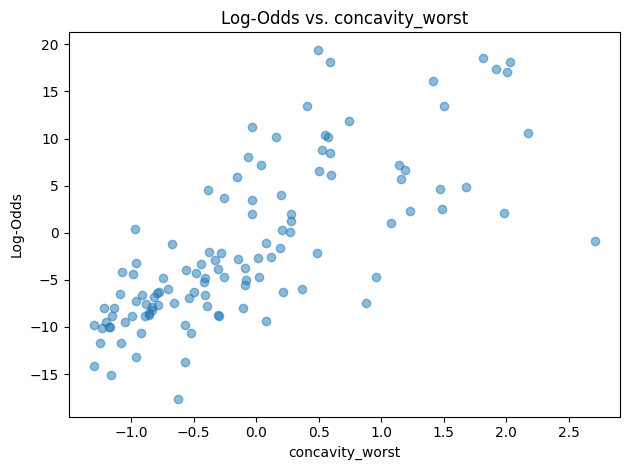

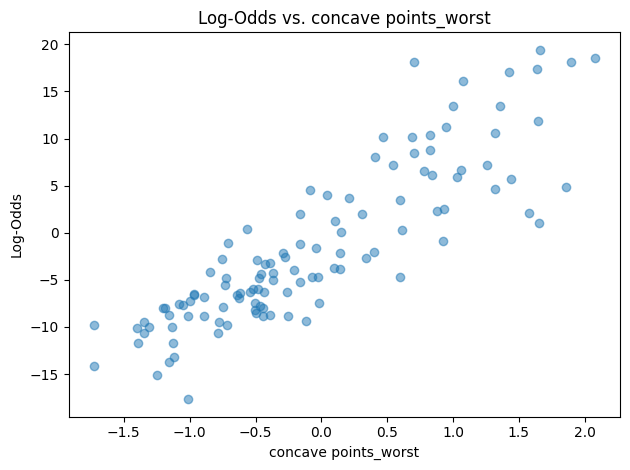

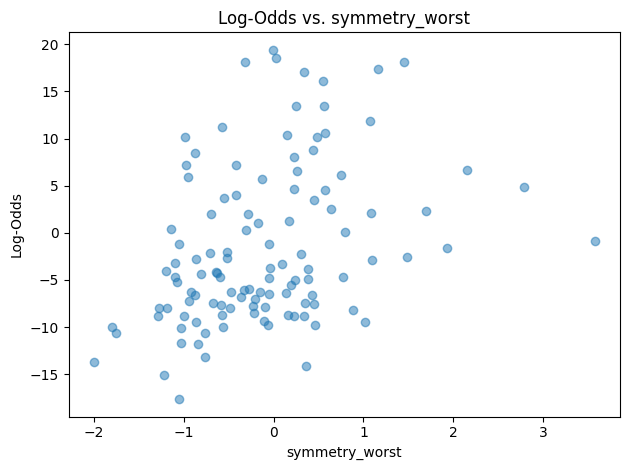

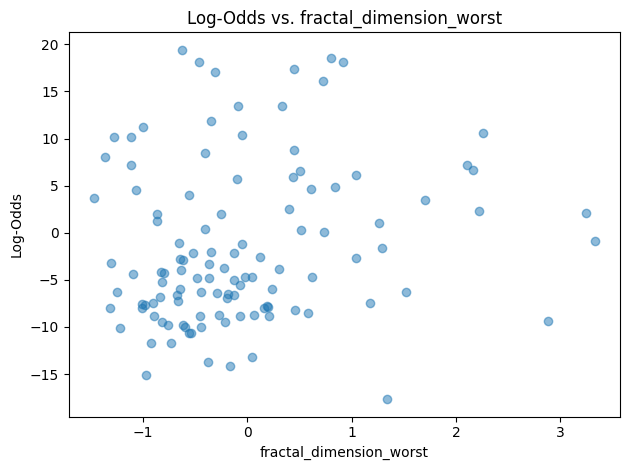

In [81]:
# Calculate log-odds for each feature
log_odds = np.dot(X_test_scaled, log_reg.coef_.T) + log_reg.intercept_

# Plot log-odds vs. predictors
for i, feature in enumerate(feature_cols):
    plt.scatter(X_test_scaled[:, i], log_odds[:, 0], alpha=0.5)
    plt.title(f'Log-Odds vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Log-Odds')
    plt.tight_layout()
    plt.show()

#### Multicollinearity (Variance Inflation Factor - VIF)

In [91]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Varaible"] = feature_cols
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]

vif_sorted = vif_data.sort_values(by="VIF", ascending=False)
print(vif_sorted.set_index("Varaible"))

                                 VIF
Varaible                            
perimeter_mean           4051.167715
radius_mean              3894.117372
radius_worst              745.233930
perimeter_worst           399.199642
area_mean                 357.286994
area_worst                236.366075
concavity_mean             72.306480
concave points_mean        65.112819
area_se                    61.244096
compactness_mean           58.425508
perimeter_se               43.421397
compactness_worst          38.458965
concave points_worst       37.174671
radius_se                  36.915049
concavity_worst            34.558648
concavity_se               22.213153
fractal_dimension_worst    20.310342
texture_worst              18.111304
compactness_se             16.643084
fractal_dimension_mean     15.569634
smoothness_worst           12.141694
texture_mean               11.692045
concave points_se          11.243382
fractal_dimension_se       10.071768
symmetry_worst             10.018128
s

#### Model Cleanup

## Model Tuning

In [ ]:
# --- Hyperparameter Tuning: Logistic Regression ---
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}
grid_search_log_reg = GridSearchCV(LogisticRegression(), param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train_scaled, y_train)
print(f"Best Parameters for Logistic Regression: {grid_search_log_reg.best_params_}")
print(f"Best Cross-Validation Accuracy for Logistic Regression: {grid_search_log_reg.best_score_}")

# Re-train Logistic Regression with Best Parameters
best_log_reg = grid_search_log_reg.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)
y_pred_log_best = best_log_reg.predict(X_test_scaled)

# Re-evaluate the Logistic Regression after tuning
print(" ")
print("Logistic Regression Performance (After Tuning):")
print(classification_report(y_test, y_pred_log_best))

# --- LIME Explanation for Logistic Regression ---
explainer_log = LimeTabularExplainer(X_train_scaled, training_labels=y_train, feature_names=feature_cols, class_names=['Benign', 'Malignant'], discretize_continuous=True)
idx = 0  # Index for the instance you want to explain (you can change this as needed)
exp_log = explainer_log.explain_instance(X_test_scaled[idx], best_log_reg.predict_proba, num_features=10)

# Show explanation for Logistic Regression
print("LIME Explanation for Logistic Regression:")
exp_log.show_in_notebook()

# Question 2: Which features influence malignancy risk the most?

In [ ]:
# --- Question 2: Which features influence malignancy risk the most? ---

feature_importance_log = pd.DataFrame({'Feature': feature_cols, 'Importance': np.abs(log_reg.coef_[0])})
feature_importance_log = feature_importance_log.sort_values(by='Importance', ascending=False)
print("Top Features Affecting Malignancy:")
print(feature_importance_log.head(10))

# Question 3: Estimated probability of malignancy

In [ ]:
# --- Question 3: Estimated probability of malignancy ---
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
df_prob = pd.DataFrame({'Actual': y_test, 'Predicted Probability': y_prob})
print("Probability Estimates:")
print(df_prob.head(10))

# Question 4: Compare Logistic Regression with Random Forest

In [ ]:
# --- Question 4: Compare Logistic Regression with Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

# Performance Comparison
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))

# --- Hyperparameter Tuning: Random Forest ---
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best Cross-Validation Accuracy for Random Forest: {grid_search_rf.best_score_}")

# Re-train Random Forest with Best Parameters
best_rf_clf = grid_search_rf.best_estimator_
best_rf_clf.fit(X_train, y_train)
y_pred_rf_best = best_rf_clf.predict(X_test)

# Re-evaluate the Random Forest after tuning
print("Random Forest Performance (After Tuning):")
print(classification_report(y_test, y_pred_rf_best))

# Feature Importance from Random Forest
feature_importance_rf = pd.DataFrame({'Feature': feature_cols, 'Importance': best_rf_clf.feature_importances_})
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False)
print("Top Features in Random Forest:")
print(feature_importance_rf.head(10))

# --- Model Validation & Reliability ---
cv_scores_log = cross_val_score(best_log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy')
cv_scores_rf = cross_val_score(best_rf_clf, X_train, y_train, cv=5, scoring='accuracy')

print(f"Logistic Regression Cross-Validation Accuracy: {np.mean(cv_scores_log):.4f}")
print(f"Random Forest Cross-Validation Accuracy: {np.mean(cv_scores_rf):.4f}")